In [5]:
# !pip install -q easydict

In [6]:
import glob
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import  DataLoader

from src.loss import vggL
from src.config import cfg, root_path
from src.data_loaders import SuperResolutionDataLoader
from src.models.srgan import Generator, Discriminator
from src.utils import show_image, plot_examples
from sklearn.model_selection import train_test_split
from src.train_validator import train_fn, validate_fn

In [7]:
# make the output dir
Path(root_path).joinpath("output/images").mkdir(exist_ok=True, parents=True)

In [8]:

# get the images dataset path
images_pth = cfg.dataset.images_dir

train_paths, test_paths = train_test_split(
    sorted(glob.glob(images_pth + "/*.*")),
    test_size=0.2,
    random_state=42,
)


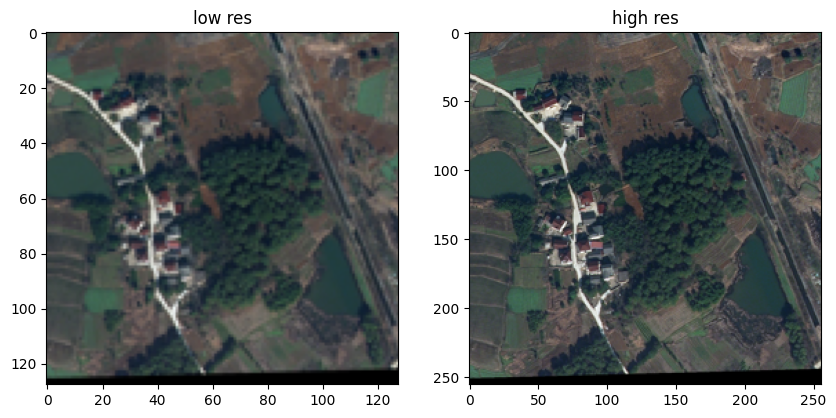

In [9]:
show_image(test_paths)

In [10]:
train = SuperResolutionDataLoader(train_paths)
train_loader = DataLoader(train, batch_size=cfg.train.batch_size, num_workers=cfg.train.n_cpu)

val = SuperResolutionDataLoader(test_paths)
val_loader = DataLoader(val, batch_size=cfg.train.batch_size, num_workers=cfg.train.n_cpu)

In [11]:


gen = Generator(in_channels=3).to(cfg.device.device)
disc = Discriminator(in_channels=3).to(cfg.device.device)
opt_gen = optim.Adam(gen.parameters(), lr=cfg.train.learning_rate, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=cfg.train.learning_rate, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/zeus/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 247MB/s] 


In [14]:
best_psnr = 0
model_save_path = "output/best_model.pth"

d_losses = []
g_losses = []
val_d_losses = []
val_g_losses = []
val_ssim = []
val_psnr = []

for epoch in range(cfg.train.n_epochs):
    print(f"Epoch {epoch + 1}/{cfg.train.n_epochs}")
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
    plot_examples(gen, train_loader, epoch)
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)

    val_gen_loss, val_disc_loss, psnr_var, ssim_var = validate_fn(val_loader, disc, gen, mse, bce, vgg_loss)
    plot_examples(gen, val_loader, epoch)

    val_ssim.append(ssim_var)
    val_psnr.append(psnr_var)
    val_d_losses.append(val_disc_loss)
    val_g_losses.append(val_gen_loss)

    # Save the model if the PSNR improves
    if psnr_var > best_psnr:
        best_psnr = psnr_var
        torch.save(gen.state_dict(), model_save_path)
        print(f"New best PSNR: {psnr_var:.4f}. Model saved.")

    print(f"Train Generator Loss: {gen_loss:.4f}, Train Discriminator Loss: {disc_loss:.4f}")
    print(f"Validation Generator Loss: {val_gen_loss:.4f}, Validation Discriminator Loss: {val_disc_loss:.4f}")
    print(f"Validation PSNR: {psnr_var:.4f}, Validation SSIM: {ssim_var:.4f}")

Epoch 1/100


  0%|          | 0/253 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Train Generator and Discriminator losses
axs[0, 0].plot(g_losses, label='Train Generator Loss', color='tab:blue')
axs[0, 0].plot(d_losses, label='Train Discriminator Loss', color='tab:orange')
axs[0, 0].set_title('Train Generator and Discriminator Losses')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Validation Generator and Discriminator losses
axs[0, 1].plot(val_g_losses, label='Validation Generator Loss', color='tab:blue', linestyle='--')
axs[0, 1].plot(val_d_losses, label='Validation Discriminator Loss', color='tab:orange', linestyle='--')
axs[0, 1].set_title('Validation Generator and Discriminator Losses')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot PSNR
axs[1, 0].plot(val_psnr, label='Validation PSNR', color='tab:green')
axs[1, 0].set_title('Validation PSNR')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('PSNR')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot SSIM
axs[1, 1].plot(val_ssim, label='Validation SSIM', color='tab:red')
axs[1, 1].set_title('Validation SSIM')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('SSIM')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Customize the overall plot layout
plt.suptitle('Training and Validation Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot
plt.savefig('training_validation_metrics.png')

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [15]:
import pandas as pd 

data = {
    'd_losses': d_losses,
    'g_losses': g_losses,
    'val_d_losses': val_d_losses,
    'val_g_losses': val_g_losses,
    'val_ssim': val_ssim,
    'val_psnr': val_psnr
}

df = pd.DataFrame(data)

df.to_csv('train_metrics.csv', index=False)
